# Topic Trends - Pandemics

This code was created from Martha and Sean's emerging topic code. 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

from brokenaxes import brokenaxes

### Data Ingestion

In [2]:
# pandemic corpus
df = pd.read_pickle("../../../data/prd/Paper/case_studies/pandemic_corpus.pkl")
df.reset_index(inplace=True, drop = True)

In [3]:
df.shape

(7571, 30)

In [4]:
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,90045,Study of Emerging Networks in Outbreak Respons...,Arts; Communicable Diseases; Communication; Co...,STUDY OF EMERGING NETWORKS IN OUTBREAK RESPONSE,NSF,NSF,NaN,0826995,9/15/2008,8/31/2012,"ANSELL, CHRISTOPHER","KELLER, ANN; REINGOLD, ARTHUR",09,124726725,UNIVERSITY OF CALIFORNIA BERKELEY,BERKELEY,CA,94704-5940,UNITED STATES,NaN,NaN,47.075,2008,726706.0,NaN,1,1,726706.0,1,study emerging networks outbreak responseprinc...
1,90243,One of the products of human development and p...,Affect; Agriculture; anthropogenesis; Award; b...,HSD: COLLABORATIVE RESEARCH: HUMAN-RELATED FAC...,NSF,NSF,NaN,0826779,10/1/2008,3/31/2012,"DASZAK, PETER","KILPATRICK, A MARM",08,077090066,ECOHEALTH ALLIANCE INC,NEW YORK,NY,10001-2320,UNITED STATES,NaN,NaN,47.075,2008,468673.0,NaN,2,2,700001.0,2,product human development population growth gl...
2,90573,Intellectual merit:The proposed project seeks ...,base; Basic Science; Biological; Biology; Bird...,COMBINING ECOLOGICAL AND MOLECULAR MODELS TO U...,NSF,NSF,NaN,0827416,9/1/2008,8/31/2011,"KOELLE, KATHARINA",NaN,04,044387793,DUKE UNIVERSITY,DURHAM,NC,27705-4010,UNITED STATES,NaN,NaN,47.074,2008,610071.0,NaN,1,1,610071.0,1,intellectual_merit propose project seek develo...
3,91397,West Nile virus re-emerges annually in urban s...,Birds; Chicago; Culicidae; Disease; Environmen...,WEST NILE VIRUS: ECO-EPIDEMIOLOGY OF DISEASE E...,NSF,NSF,NaN,0840403,9/1/2008,8/31/2012,"GOLDBERG, TONY L.","BRAWN, JEFFREY; RUIZ, MARILYN; KITRON, URIEL; ...",02,003255648,UNIVERSITY OF WISCONSIN SYSTEM,MADISON,WI,53715-1218,UNITED STATES,NaN,NaN,47.074,2008,1964529.0,NaN,1,1,1964529.0,1,west_nile virus emerge annually urban setting ...
4,93669,About five percent of the world's population d...,Affect; Disabled Persons; Disease; Emerging Co...,RESEARCH STARTER: POPULATION DYNAMICS AND EVOL...,NSF,NSF,NaN,0804039,8/1/2008,7/31/2010,"DENNEHY, JOHN J",NaN,09,064932676,RESEARCH FOUNDATION OF THE CITY UNIVERSITY OF ...,FLUSHING,NY,11367-1575,UNITED STATES,NaN,NaN,47.074,2008,67848.0,NaN,1,1,67848.0,1,percent world population die major influenza p...


In [5]:
# input needed for NMF (from Scikit-Learn) is one string per document (not a list of strings)

text = df["final_tokens"]

In [6]:
cb_pal = {"blue":'#377eb8', "orange":'#ff7f00', "green":'#4daf4a', "pink":'#f781bf', "brown":'#a65628', 
          "purple":'#984ea3', "gray":'#999999', "red":'#e41a1c', "yellow":'#dede00'}

### Functions needed for all models

In [7]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [8]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF

In [9]:
stop_wds = ['research', 'aim', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [10]:
# create model

num_topics = 5

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 0.9463694095611572


In [11]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('virus', 2.0216829783033554)
('viral', 0.9358136457443543)
('cell', 0.901051314885802)
('host', 0.815276009849738)
('infection', 0.7041209921987562)
('protein', 0.5882825686777636)
('human', 0.5485464378117804)
('rna', 0.46299339074082957)
('mechanism', 0.45091794263782287)
('iav', 0.44282373158706134)

Topic 1:
('covid_19', 0.8664506653632997)
('health', 0.6262634562108604)
('datum', 0.5135191924818354)
('disease', 0.45804644203248046)
('community', 0.42187360014807984)
('social', 0.41109358458436335)
('student', 0.37675914723948417)
('program', 0.37212367388726336)
('public', 0.3632433355814631)
('training', 0.36315652655532077)

Topic 2:
('influenza', 2.9484043793469503)
('virus', 0.4684515988537173)
('vaccination', 0.43762710418123096)
('protection', 0.37350841972816395)
('immune', 0.31705834759852347)
('strain', 0.30644052747058115)
('infection', 0.2826692567260045)
('pandemic', 0.2757569569754874)
('animal', 0.27164585964439875)
('study', 0.2378350199695247)

Topic 3:


### Topic Trends

In [12]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["FY"] = df["FY"]

In [13]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,FY
0,0.008453,0.070491,0.000000,0.006587,0.000000,2008
1,0.011856,0.093195,0.002247,0.005622,0.000000,2008
2,0.031024,0.048031,0.018321,0.002859,0.002038,2008
3,0.038526,0.021551,0.008096,0.000000,0.000000,2008
4,0.033527,0.034447,0.014583,0.000000,0.000000,2008
...,...,...,...,...,...,...
7566,0.000000,0.086012,0.000000,0.000000,0.000000,2020
7567,0.007065,0.111172,0.000000,0.003798,0.000000,2020
7568,0.000000,0.075991,0.000000,0.000000,0.000000,2020
7569,0.004859,0.107299,0.000000,0.000000,0.000000,2020


#### compute count of projects with weight > 0 for each topic

In [14]:
topic_proj_count = topic_frame.copy()

In [15]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,FY
0,0.008453,0.070491,0.000000,0.006587,0.000000,2008
1,0.011856,0.093195,0.002247,0.005622,0.000000,2008
2,0.031024,0.048031,0.018321,0.002859,0.002038,2008
3,0.038526,0.021551,0.008096,0.000000,0.000000,2008
4,0.033527,0.034447,0.014583,0.000000,0.000000,2008


In [16]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["FY"] = topic_proj_count["FY"]

In [17]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,FY
0,True,True,False,True,False,2008
1,True,True,True,True,False,2008
2,True,True,True,True,True,2008
3,True,True,True,False,False,2008
4,True,True,True,False,False,2008
...,...,...,...,...,...,...
7566,False,True,False,False,False,2020
7567,True,True,False,True,False,2020
7568,False,True,False,False,False,2020
7569,True,True,False,False,False,2020


In [18]:
topic_count_bool.sum(axis=1).median()

3.0

In [19]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("FY").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "FY")  # pretty sure this is unnecessary
topic_counts["FY"] = topic_counts["FY"].astype(int)

In [20]:
topic_counts

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,2008,398,315,314,343,246
1,2009,471,382,369,409,294
2,2010,454,376,375,403,315
3,2011,438,357,367,379,313
4,2012,367,320,311,309,245
5,2013,344,290,279,288,230
6,2014,317,269,259,279,221
7,2015,355,299,297,319,229
8,2016,369,321,297,319,253
9,2017,384,328,285,325,256


In [21]:
# note if filtering data set to specific years - set here

year_st = 2008
year_end = 2020

In [22]:
topic_counts_filt = topic_counts[topic_counts["FY"] >= year_st] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["FY"] <= year_end]

In [23]:
topic_counts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,2008,398,315,314,343,246
1,2009,471,382,369,409,294
2,2010,454,376,375,403,315
3,2011,438,357,367,379,313
4,2012,367,320,311,309,245
5,2013,344,290,279,288,230
6,2014,317,269,259,279,221
7,2015,355,299,297,319,229
8,2016,369,321,297,319,253
9,2017,384,328,285,325,256


In [24]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0    5922
Topic 1    5766
Topic 2    4563
Topic 3    5120
Topic 4    3825
dtype: int64

#### calculate mean topic weight by year and standard errors on means

In [25]:
topic_frame_se = topic_frame.groupby("FY").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "FY")
topic_frame_se["FY"] = topic_frame_se["FY"].astype(int)

topic_wts_se_filt = topic_frame_se[topic_frame_se["FY"] >= year_st] 
topic_wts_se_filt = topic_wts_se_filt[topic_wts_se_filt["FY"] <= year_end]

In [26]:
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "FY")
topic_frame["FY"] = topic_frame["FY"].astype(int)

In [27]:
topic_frame

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,2008,0.027815,0.014800,0.023467,0.025518,0.016626
1,2009,0.027890,0.015676,0.022493,0.024479,0.015727
2,2010,0.026359,0.016341,0.023367,0.024689,0.016444
3,2011,0.026735,0.016493,0.023619,0.024061,0.018331
4,2012,0.027562,0.016949,0.022531,0.023608,0.019475
5,2013,0.027913,0.015495,0.022883,0.022626,0.017114
6,2014,0.026680,0.015743,0.021991,0.025266,0.017119
7,2015,0.026672,0.015698,0.022950,0.026195,0.014336
8,2016,0.026955,0.015142,0.023014,0.023598,0.015531
9,2017,0.027116,0.013918,0.021161,0.022717,0.014756


In [28]:
# filter topic_frame for years 

topic_wts_filt = topic_frame[topic_frame["FY"] >= year_st] 
topic_wts_filt = topic_wts_filt[topic_wts_filt["FY"] <= year_end] 

In [29]:
topic_wts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,2008,0.027815,0.014800,0.023467,0.025518,0.016626
1,2009,0.027890,0.015676,0.022493,0.024479,0.015727
2,2010,0.026359,0.016341,0.023367,0.024689,0.016444
3,2011,0.026735,0.016493,0.023619,0.024061,0.018331
4,2012,0.027562,0.016949,0.022531,0.023608,0.019475
5,2013,0.027913,0.015495,0.022883,0.022626,0.017114
6,2014,0.026680,0.015743,0.021991,0.025266,0.017119
7,2015,0.026672,0.015698,0.022950,0.026195,0.014336
8,2016,0.026955,0.015142,0.023014,0.023598,0.015531
9,2017,0.027116,0.013918,0.021161,0.022717,0.014756


In [30]:
topic_wts_se_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,2008,0.001048,0.000897,0.001584,0.001503,0.001524
1,2009,0.000929,0.000850,0.001463,0.001403,0.001345
2,2010,0.000927,0.000896,0.001475,0.001435,0.001354
3,2011,0.000997,0.000943,0.001534,0.001447,0.001479
4,2012,0.001060,0.000991,0.001708,0.001563,0.001686
5,2013,0.001153,0.000996,0.001723,0.001576,0.001595
6,2014,0.001222,0.001045,0.001737,0.001699,0.001669
7,2015,0.001132,0.001018,0.001692,0.001650,0.001501
8,2016,0.001120,0.000919,0.001661,0.001551,0.001601
9,2017,0.001058,0.000857,0.001575,0.001450,0.001508


In [31]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [32]:
topic_slopes[:5]

[-0.0005611047061712948,
 0.0010380678476662266,
 -0.0004931200663533,
 -0.0005699634737529191,
 -0.0005983384597360072]

In [33]:
p_values[:5]

[0.0328172332450205,
 0.17333106236335905,
 0.16936978222655968,
 0.050616687418510956,
 0.01102895665048791]

In [34]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [35]:
leg[:5]

['virus, viral, cell, host, infection',
 'covid_19, health, datum, disease, community',
 'influenza, virus, vaccination, protection, immune',
 'vaccine, antibody, virus, protective, response',
 'hiv, aids, hiv_1, drug, cell']

In [36]:
n_by_topic.values

array([5922, 5766, 4563, 5120, 3825])

In [37]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["n"] = n_by_topic.values
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "p%d" % (i+1)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [38]:
reg_topics

,Label,n,Slopex100,p-value,Topic Words
1,p1,5766,0.103807,0.173331,"covid_19, health, datum, disease, community"
4,p2,3825,-0.059834,0.011029,"hiv, aids, hiv_1, drug, cell"
2,p3,4563,-0.049312,0.169370,"influenza, virus, vaccination, protection, immune"
3,p4,5120,-0.056996,0.050617,"vaccine, antibody, virus, protective, response"
0,p5,5922,-0.056110,0.032817,"virus, viral, cell, host, infection"


In [81]:
#reg_topics.to_csv("./csvs/pan_20topics.csv", index=False)

## Grid Plot

In [39]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [40]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:5] # sort_slopes now goes from 0 to 29

[(1, 0.0010380678476662266),
 (2, -0.0004931200663533),
 (0, -0.0005611047061712948),
 (3, -0.0005699634737529191),
 (4, -0.0005983384597360072)]

In [41]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[1, 2, 0, 3, 4]

In [42]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx-1] + ' \n' + title[idx:])
    

In [43]:
new_leg

['virus, viral, cell \n host, infection',
 'covid_19, health, datum \n disease, community',
 'influenza, virus, vaccination \n protection, immune',
 'vaccine, antibody, virus \n protective, response',
 'hiv, aids, hiv_1 \n drug, cell']

In [44]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [45]:
order_df

,Topic Words
0,"virus, viral, cell, host, infection"
1,"covid_19, health, datum, disease, community"
2,"influenza, virus, vaccination, protection, immune"
3,"vaccine, antibody, virus, protective, response"
4,"hiv, aids, hiv_1, drug, cell"


In [46]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [47]:
L_df

,Topic Words,Label
0,"virus, viral, cell, host, infection",p5
1,"covid_19, health, datum, disease, community",p1
2,"influenza, virus, vaccination, protection, immune",p3
3,"vaccine, antibody, virus, protective, response",p4
4,"hiv, aids, hiv_1, drug, cell",p2


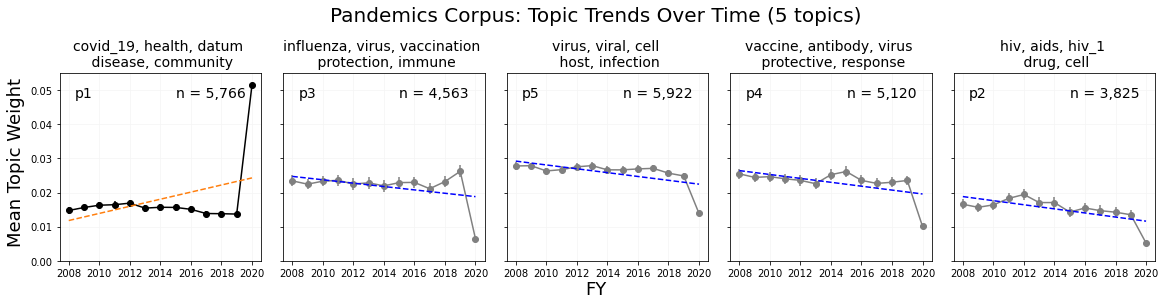

In [49]:
# set up grid
fig, ax = plt.subplots(1, 5, sharex = True, sharey = True, figsize=(16,4))
plt.ylim(bottom = 0.00, top = 0.055) 
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_filt.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    if(count in [0]): # upward trend in 2020, 20: [0,1,4,9,12]
        line_color = 'black'
    else: # downward trend in 2020
        line_color = 'gray'
    
    ax[j].errorbar(topic_wts_filt["FY"], topic_wts_filt[col], 
            yerr = np.array(topic_wts_se_filt[col]), fmt = '-o', color = line_color, zorder = 10) 
    
    ax[j].plot(topic_wts_filt["FY"], \
        (topic_wts_filt["FY"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[j].set_title(new_leg[col_idx], fontsize = 14)
    
    # add topic number to each plot
    ax[j].text(0.12, 0.89, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[j].text(0.75, 0.89, "n = " + f"{n_by_topic[col_idx]:,}", horizontalalignment='center', verticalalignment='center', \
                 transform=ax[j].transAxes, fontsize = 14)
    
    
fig.suptitle('Pandemics Corpus: Topic Trends Over Time (5 topics)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.75)

#plt.savefig("./figures/pan_05topic_trends.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_05topic_trends.pdf", dpi = 800, bbox_inches = "tight")
plt.show()